Back to the main [Index](../index.ipynb) <a id="top"></a>

# Elastic and piezoelectric properties with Abinit and AbiPy

This tutorial shows how to calculate the following physical properties related to strain:

  * the *clamped-ion* elastic tensor 
  * the *clamped-ion* piezoelectric tensor (insulators only) 
  * the *internal* strain tensor 
  * the atomic relaxation corrections to the elastic and piezoelectric tensor (*relaxed-ion tensors*)
  
The discussion is based on the [tutorial on elastic properties](https://docs.abinit.org/tutorial/elastic/)
available on the Abinit web site. 
More specifically, we will discuss how to

   * build a flow to compute all the ingredients needed for elastic and piezoelectric tensors
   * use anaddb and AbiPy to obtain the tensors and compute several important physical properties 
     starting from the final DDB file produced by the flow
   * perform a convergence study with respect to the k-mesh and use the `DdbRobot` to analyze the convergence.

You might find additional material related to the present section
in the following references (already mentioned in the official tutorial): 

* [Systematic treatment of displacements, strains, and electric fields in density-functional perturbation theory](http://dx.doi.org/10.1103/physrevb.72.035105)
* [Metric tensor formulation of strain in density-functional perturbation theory](https://doi.org/10.1103/physrevb.71.035117)

The first paper provides a detailed discussion of the theory underlying the incorporation 
of atom-relaxation corrections. 
We strongly recommend to read this article as this notebook will mainly focus on the usage
of the python API assuming you are already familiar with the theoretical aspects.
The second paper discusses in more details the DFPT treatment of strain perturbations in Abinit.

If you are already familiar with python and AbiPy-Abinit are already installed and configured,
you may want to use directly the command line interface.
There is a README.md file in the directory of this lesson explaining how to analyze the data from the shell
using ipython and matplotlib.

Note: The code in this notebook requires abinit >= 8.9 and abipy >= 0.6


## Table of Contents
[[back to top](#top)]

- [DFPT calculation of elastic and piezoelectric tensors](#DFPT-calculation-of-elastic-and-piezolectric-tensors)
- [Post-processing the results](#Post-processing-the-results)
- [Convergence study with respect to the number of k-points](#Convergence-study-wrt-the-number-of-k-points)
- [Exercises](#Exercises)

## DFPT calculation of elastic and piezolectric tensors
[[back to top](#top)]

Before starting, we need to import the python modules and the functions needed in the notebook:

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np
import warnings
warnings.filterwarnings("ignore") # to get rid of deprecation warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook
import abipy.flowtk as flowtk

# This line configures matplotlib to show figures embedded in the notebook.
# Replace `inline` with `notebook` in classic notebook
%matplotlib inline   

# Option available in jupyterlab. See https://github.com/matplotlib/jupyter-matplotlib
#%matplotlib widget 

and an useful function from the `lesson_elastic` module required to generate our DFPT flows:

In [2]:
from lesson_elastic import make_scf_input
abilab.print_source(make_scf_input)

The function makes some assumptions for important parameters such as 
the crystalline structure and the pseudos. 
This is done on purpose to keep the code as simple as possible.
It should not be so difficult to generalize the implementation to take into account other cases.
Note how the function accepts an optional argument `ngkpt` defining the k-mesh so that we can easily 
change the sampling e.g. for convergence studies.

Let's start to play with our new function:

In [3]:
scf_input = make_scf_input()
scf_input

<AbinitInput at 4686695896>

In [4]:
print(scf_input.structure)

Full Formula (Al2 As2)
Reduced Formula: AlAs
abc   :   3.989448   3.989448   6.497130
angles:  90.000000  90.000000 120.000000
Sites (4)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Al    0.333333  0.666667  0
  1  Al    0.666667  0.333333  0.5
  2  As    0.333333  0.666667  0.376086
  3  As    0.666667  0.333333  0.876086


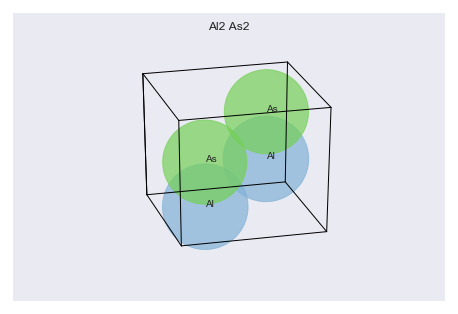

In [5]:
scf_input.structure.plot();

We are using the same norm-conserving pseudopotentials of the official tutorial but
this does not mean you should use them for production calculations (there must be a reason
why the directory is called **Psps_for_tests**).

There are 16 valence electrons per unit cell hence `nband` has been set to 8 
(yes, we are dealing with a non-magnetic semiconductor):

In [6]:
for pseudo in scf_input.pseudos:
    print(pseudo, "\n")

<NcAbinitPseudo: 13al.pspnc>
  summary: Troullier-Martins psp for element  Al        Thu Oct 27 17:31:05 EDT 1994
  number of valence electrons: 3.0
  maximum angular momentum: d
  angular momentum for local part: d
  XC correlation: LDA_XC_TETER93
  supports spin-orbit: False
  radius for non-linear core correction: 2.09673076353074
  hint for low accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for normal accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for high accuracy: ecut: 0.0, pawecutdg: 0.0 

<NcAbinitPseudo: 33as.pspnc>
  summary: Troullier-Martins psp for element  As        Thu Oct 27 17:37:14 EDT 1994
  number of valence electrons: 5.0
  maximum angular momentum: p
  angular momentum for local part: p
  XC correlation: LDA_XC_TETER93
  supports spin-orbit: False
  radius for non-linear core correction: 2.0573171556401
  hint for low accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for normal accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for high accuracy: ecut: 0.0, pawecutdg: 0.0 



The `scf_input` represents the **building block** for our DFPT calculation.
As usual, AbiPy provides a `Work` to compute elastic and piezoelectric properties
starting from an input representing a ground-state calculation
thus it is just a matter of calling `make_scf_input` and pass the result to
`ElasticWork.from_scf_input` to construct our flow.

Let's have a look at the actual implementation:

In [7]:
from lesson_elastic import build_flow
abilab.print_source(build_flow)

Now we can call the function to build our flow:

In [8]:
flow = build_flow()
flow.show_info()

<Flow, node_id=345805, workdir=flow_elastic>
Number of works: 1, total number of tasks: 14
Number of tasks with a given class:

Task Class      Number
------------  --------
ScfTask              1
DdkTask              3
PhononTask           4
ElasticTask          6

and use the `get_graphviz` method to visualize the connection among the `Tasks`:

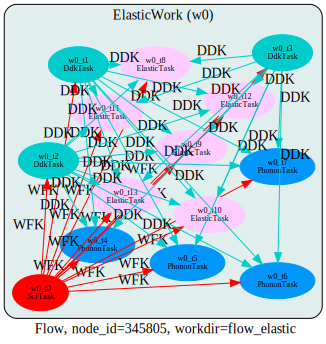

In [9]:
flow.get_graphviz()

In [10]:
# matplotlib version based on networkx
#flow.plot_networkx(with_edge_labels=True);

In a nutshell: 

   * we compute the `WFK` file in the `ScfTask` (red circle)
   * the ground-state wavefunctions are used by the three `DdkTasks` to compute $\dfrac{\partial u}{\partial{\bf k}}$ for the three different directions. 
   * The `ElasticTasks` needs the `WFK` file to compute the six strain perturbations (3 for uniaxial and 3 for shear strain) while the `DDK` files are required to compute the mixed 2nd-order derivatives with respect to strain and electric field needed for the piezoelectric tensor. 

Note that, **contrarily to the approach used in the standard tutorial**, 
the AbiPy `Work` does not use datasets.
The perturbations of interest (strain, atomic-perturbation, ddk, electric field)
are obtained with different `Tasks` that can be executed in parallel.

To understand better this point, we can print a table with the most important Abinit variables defining
the DFPT calculation.
If the variable is not present in the input, the entry is set to `None`. 

In [11]:
flow.get_vars_dataframe("qpt", "rfphon", "rfatpol", "rfdir", "rfelfd", "rfstrs", "kptopt")

,qpt,rfphon,rfatpol,rfdir,rfelfd,rfstrs,kptopt,class
w0_t0,None,None,None,None,None,None,None,ScfTask
w0_t1,"(0, 0, 0)",None,None,"(1, 0, 0)",2,None,2,DdkTask
w0_t2,"(0, 0, 0)",None,None,"(0, 1, 0)",2,None,2,DdkTask
w0_t3,"(0, 0, 0)",None,None,"(0, 0, 1)",2,None,2,DdkTask
w0_t4,"(0, 0, 0)",1,"[1, 1]","[1, 0, 0]",None,None,2,PhononTask
w0_t5,"(0, 0, 0)",1,"[1, 1]","[0, 0, 1]",None,None,2,PhononTask
w0_t6,"(0, 0, 0)",1,"[3, 3]","[1, 0, 0]",None,None,2,PhononTask
w0_t7,"(0, 0, 0)",1,"[3, 3]","[0, 0, 1]",None,None,2,PhononTask
w0_t8,"(0, 0, 0)",None,None,"[1, 0, 0]",None,1,2,ElasticTask
w0_t9,"(0, 0, 0)",None,None,"[0, 1, 0]",None,1,2,ElasticTask


If the meaning of these variables is not clear, you can consult the [Abinit documentation](https://docs.abinit.org)
or access the documentation directly from python with *e.g.*: 

In [12]:
abilab.docvar("rfstrs")

rfstrs  <Response Function with respect to STRainS>

Now we can generate the `flow_elastic` directory with the input files by executing 
the `lesson_elastic.py` script.
Then use the `abirun.py` script to launch the entire calculation with:

    abirun.py flow_elastic scheduler
    
You will see that all `PhononTasks` and `ElasticTasks` are executed in parallel on your machine
once the three `DdkTasks` are completed.

<div class="alert alert-warning">
Please make sure that AbiPy is properly configured by running abicheck --with flow
</div>

If you prefer to skip this part, you may want to jump to next section about the post-processing of the results.
Note that the output files are already available in the repository so it is also possible to try 
the AbiPy post-processing tools without having to run the flow.

## Post-processing the results
[[back to top](#top)]

Our flow is completed and we have the final DDB file 
in the `outdata` directory of the `Work` (AbiPy has automatically merged all the partial DDB files
at the end of the calculation by invoking `anaddb` for you).
Let's open this DDB file with:

In [13]:
ddb = abilab.abiopen("flow_elastic/w0/outdata/out_DDB")
print(ddb)

================================= File Info =================================
Name: out_DDB
Directory: /Users/gmatteo/git_repos/abitutorials/abitutorials/elastic/flow_elastic/w0/outdata
Size: 27.03 kb
Access Time: Sun Aug 12 01:23:46 2018
Modification Time: Wed Aug  1 15:26:42 2018
Change Time: Wed Aug  1 15:26:42 2018

================================= Structure =================================
Full Formula (Al2 As2)
Reduced Formula: AlAs
abc   :   3.989448   3.989448   6.497130
angles:  90.000000  90.000000 120.000000
Sites (4)
  #  SP           a         b         c  cartesian_forces
---  ----  --------  --------  --------  -------------------------------------------------
  0  Al    0.333333  0.666667  0         [-0.00000000e+00 -0.00000000e+00  4.06423231e-06]
  1  Al    0.666667  0.333333  0.5       [-0.00000000e+00 -0.00000000e+00  4.06423231e-06]
  2  As    0.333333  0.666667  0.376086  [-0.00000000e+00 -0.00000000e+00 -4.06423231e-06]
  3  As    0.666667  0.333333  0.876086  

The `DdbFile` object provides an easy-to-use interface that invokes `anaddb` to post-process
the data stored in the DDB file.
All the methods that invoke `anaddb` use the `ana` prefix so it is not strange to 
see that we can obtain the elastic and piezoelectric tensors by just calling:

In [14]:
edata = ddb.anaget_elastic(verbose=1)

ANADDB INPUT:
  asr 2
 chneut 1
 dieflag 0
 elaflag 3
 piezoflag 3
 instrflag 1
workdir: /var/folders/89/47k8wfdj11x035svqf8qnl4m0000gn/T/tmpyuscipwb


Note that we are calling the method without arguments. This means that AbiPy will try to detect
**automatically** how to set the anaddb input variables.
The docstring of the method explains the logic used to set the variables.

In [15]:
abilab.print_doc(ddb.anaget_elastic)

Let's print the object to get a summary of the most important results:

In [16]:
print(edata)

================================= Structure =================================
Full Formula (Al2 As2)
Reduced Formula: AlAs
abc   :   3.989448   3.989448   6.497130
angles:  90.000000  90.000000 120.000000
Sites (4)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Al    0.333333  0.666667  0
  1  Al    0.666667  0.333333  0.5
  2  As    0.333333  0.666667  0.376086
  3  As    0.666667  0.333333  0.876086

============================== Anaddb Variables ==============================
{
  "asr": 2,
  "chneut": 1,
  "dieflag": 0,
  "elaflag": 3,
  "instrflag": 1,
  "piezoflag": 3
}

========================= elastic tensors available =========================
[ELASTIC_RELAXED]
relaxed-ion elastic tensor in Voigt notation (shape: (6, 6))
Units: GPa, set to zero below: 0.001, fit_to_structure: True

            xx          yy          zz         yz         xz         xy
xx  135.262181   54.450372   38.052925   0.000000   0.000000   0.000000
yy   54.450375 

Since the DDB file contains `internal strain terms` and piezoeletric terms, 
AbiPy set `elaflag` to 3, `instrflag` to 1 and `piezoflag` to 3 so that anaddb 
will compute both `relaxed` and `clamped-ion` tensors.

In [17]:
abilab.docvar("elaflag", executable="anaddb")

elaflag@anaddb  <ELAstic tensor FLAG>

The tensors are available as attributes of the `edata` object:

In [18]:
edata.elastic_relaxed

,xx,yy,zz,yz,xz,xy
xx,135.262181,54.450372,38.052925,0.000000,0.000000,0.000000
yy,54.450375,135.262187,38.052928,0.000000,0.000000,0.000000
zz,38.052913,38.052919,148.211036,0.000000,0.000000,0.000000
yz,0.000000,0.000000,0.000000,30.550711,0.000000,0.000000
xz,0.000000,0.000000,0.000000,0.000000,30.550712,0.000000
xy,0.000000,0.000000,0.000000,0.000000,0.000000,40.405889


These are pymatgen [tensors](https://github.com/materialsproject/pymatgen/blob/master/pymatgen/analysis/elasticity/tensors.py),
more specifically [ElasticTensor objects](https://github.com/materialsproject/pymatgen/blob/master/pymatgen/analysis/elasticity/elastic.py)
so we have access to several useful methods.
To get the Voigt bulk modulus, use:

In [19]:
edata.elastic_relaxed.k_voigt

75.53864863605261

while the compliance tensor is easily obtained with:

In [20]:
edata.elastic_relaxed.compliance_tensor

ComplianceTensor([[[[ 9.12540929e-03  3.25441510e-10 -1.35432125e-11]
   [ 3.25441510e-10 -3.24901951e-03  5.16094245e-13]
   [-1.35432125e-11  5.16094245e-13 -1.50875274e-03]]

  [[ 1.06681420e-10  6.18721684e-03  2.11485691e-13]
   [ 6.18721684e-03 -4.62436076e-10 -9.82857846e-13]
   [ 2.11485691e-13 -9.82857846e-13 -3.61800362e-11]]

  [[-1.49199040e-11  2.11490978e-13  8.18311527e-03]
   [ 2.11490978e-13  8.81357843e-12  2.09475879e-12]
   [ 8.18311527e-03  2.09475879e-12  4.38679338e-12]]]


 [[[ 1.06681420e-10  6.18721684e-03  2.11485691e-13]
   [ 6.18721684e-03 -4.62436076e-10 -9.82857846e-13]
   [ 2.11485691e-13 -9.82857846e-13 -3.61800362e-11]]

  [[-3.24901979e-03 -4.83938131e-10  7.06881323e-12]
   [-4.83938131e-10  9.12540907e-03 -7.21983061e-13]
   [ 7.06881323e-12 -7.21983061e-13 -1.50875291e-03]]

  [[-8.81461360e-14 -1.01064570e-12  2.09475590e-12]
   [-1.01064570e-12 -7.17076965e-13  8.18311563e-03]
   [ 2.09475590e-12  8.18311563e-03 -2.56162853e-13]]]


 [[[-1.491990

One can also use the [elate](http://progs.coudert.name/elate) online tool to analyse the elastic tensor.

To build a pandas DataFrame with properties derived from the elastic tensor
and the associated structure, use:

In [21]:
edata.get_elastic_properties_dataframe(properties_as_index=True)

,property,0,1
0,trans_v,3.194459e+03,3.838052e+03
1,long_v,5.796035e+03,6.295200e+03
2,snyder_ac,5.767044e+01,8.693459e+01
3,snyder_opt,3.158141e-01,3.621134e-01
4,snyder_total,5.798626e+01,8.729671e+01
5,clarke_thermalcond,7.734051e-01,9.006348e-01
6,cahill_thermalcond,8.539415e-01,9.791320e-01
7,debye_temperature,3.760623e+02,4.477874e+02
8,k_voigt,7.553865e+01,7.553930e+01
9,k_reuss,7.553073e+01,7.553578e+01


For the meaning of the different quantities please consult the 
[pymatgen module](https://github.com/materialsproject/pymatgen/blob/master/pymatgen/analysis/elasticity/elastic.py).

To construct a dataframe with the Voigt indices and the tensor elements use:

In [22]:
edata.get_elastic_voigt_dataframe(tol=1e-5)

,voigt_cinds,elastic_relaxed,elastic_clamped
0,"(0, 0)",135.262181,165.988592
1,"(0, 1)",54.450372,40.464801
2,"(0, 2)",38.052925,21.090299
3,"(0, 3)",0.000000,0.000000
4,"(0, 4)",0.000000,0.000000
5,"(0, 5)",0.000000,0.000000
6,"(1, 0)",54.450375,40.464804
7,"(1, 1)",135.262187,165.988593
8,"(1, 2)",38.052928,21.090296
9,"(1, 3)",0.000000,0.000000


Note that the Voigt indices are given following the Python (C) notation 
in which we start to count from zero.

This might be a bit confusing, especially when comparing with results reported in the literature.
The reason why we opted with the 0-based notation is that it facilitates the integration between 
the DataFrame and other python methods. 
A similar approach is used in AbiPy when e.g. one has to specify the band or the phonon mode index.

At this point, it should be clear how to analyze the *relaxed-ion* piezoelectric tensor:

In [23]:
edata.piezo_relaxed

,xx,yy,zz,yz,xz,xy
Px,0.000000,0.000000,0.000000,0.000000,-0.048288,0.0
Py,0.000000,0.000000,0.000000,-0.048288,0.000000,0.0
Pz,-0.011871,-0.011872,0.064628,0.000000,0.000000,0.0


In [24]:
edata.get_piezo_voigt_dataframe(tol=1e-6)

,voigt_cinds,piezo_relaxed,piezo_clamped
0,"(0, 0)",0.000000,0.000000
1,"(0, 1)",0.000000,0.000000
2,"(0, 2)",0.000000,0.000000
3,"(0, 3)",0.000000,0.000000
4,"(0, 4)",-0.048288,0.435488
5,"(0, 5)",0.000000,0.000000
6,"(1, 0)",0.000000,0.000000
7,"(1, 1)",0.000000,0.000000
8,"(1, 2)",0.000000,0.000000
9,"(1, 3)",-0.048288,0.435488


## Convergence study wrt the number of k-points
[[back to top](#top)]

In this part of the tutorial, we discuss how to compute elastic and piezoelectric 
tensors with different k-point meshes and how to use the `DdbRobot` to analyze the results.

In principle, one should relax the structure with different k-point samplings and then
use the relaxed structure to compute elastic and piezoelectric properties.
This is easy with AbiPy but, for the time being, we ignore this point and use 
the same structure so that we can learn how to use Python to analyze multiple calculations.
At the end of this tutorial you will find an example of flow in which the structural relaxation
is performed with different k-meshes.

Since we do not have to change the structure, performing a convergence study with respect to k-points 
is just a matter of creating multiple `Works` inside a loop over k-meshes (our `make_scf_input`
is already accepting `ngkpt` in input):

In [25]:
from lesson_elastic import build_ngkpt_convflow
abilab.print_source(build_ngkpt_convflow)

In [26]:
ngkpt_flow = build_ngkpt_convflow(options=None, ngkpt_list=([2, 2, 2], [4, 4, 4], [8, 8, 8]))

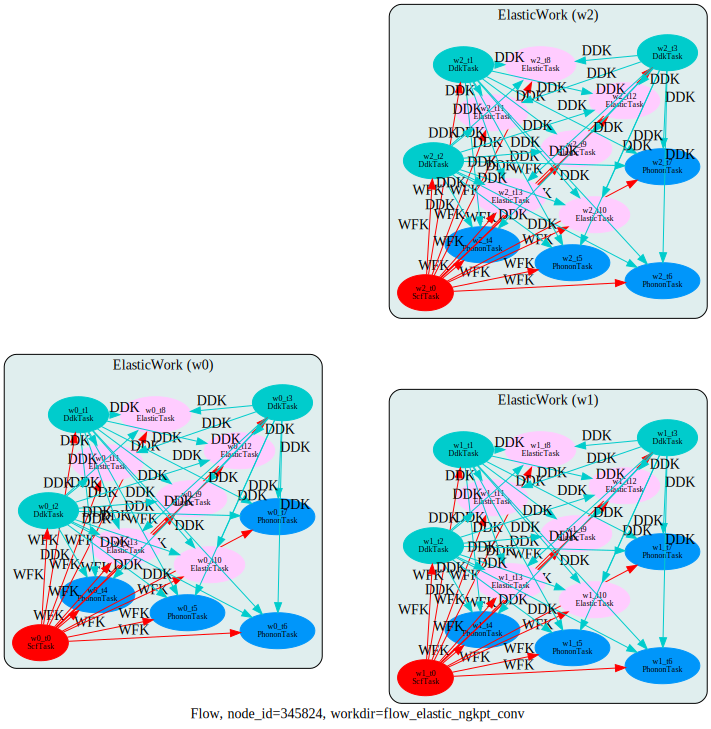

In [27]:
ngkpt_flow.get_graphviz()

In [28]:
#ngkpt_flow.get_vars_dataframe("ngkpt")

To generate the flow with the `lesson_elastic.py` script, open the file,
comment the call to `build_flow` and uncomment `build_ngkpt_convflow`.
Then run the script and launch the calculation with:

    abirun.py flow_elastic_ngkpt_conv scheduler
    
as usual.

There are several output files located inside the `outdata` directories:

In [29]:
!find flow_elastic_ngkpt_conv/ -name "*_DDB"

flow_elastic_ngkpt_conv//w0/outdata/out_DDB
flow_elastic_ngkpt_conv//w0/t0/outdata/out_DDB
flow_elastic_ngkpt_conv//w0/t10/outdata/out_DDB
flow_elastic_ngkpt_conv//w0/t11/outdata/out_DDB
flow_elastic_ngkpt_conv//w0/t12/outdata/out_DDB
flow_elastic_ngkpt_conv//w0/t13/outdata/out_DDB
flow_elastic_ngkpt_conv//w0/t4/outdata/out_DDB
flow_elastic_ngkpt_conv//w0/t5/outdata/out_DDB
flow_elastic_ngkpt_conv//w0/t6/outdata/out_DDB
flow_elastic_ngkpt_conv//w0/t7/outdata/out_DDB
flow_elastic_ngkpt_conv//w0/t8/outdata/out_DDB
flow_elastic_ngkpt_conv//w0/t9/outdata/out_DDB
flow_elastic_ngkpt_conv//w1/outdata/out_DDB
flow_elastic_ngkpt_conv//w1/t0/outdata/out_DDB
flow_elastic_ngkpt_conv//w1/t10/outdata/out_DDB
flow_elastic_ngkpt_conv//w1/t11/outdata/out_DDB
flow_elastic_ngkpt_conv//w1/t12/outdata/out_DDB
flow_elastic_ngkpt_conv//w1/t13/outdata/out_DDB
flow_elastic_ngkpt_conv//w1/t4/outdata/out_DDB
flow_elastic_ngkpt_conv//w1/t5/outdata/out_DDB
flow_elastic_ngkpt_conv//w1/t6/outdata/out_DDB
flow_elasti

Remember that our goal is to analyze the convergence of the elastic and piezoeletric properties
as function of `nkpt`.
So we are mainly interested in the final DDB files located in the `outdata` directories 
of the works (`w0/outdata`, `w1/outdata`, `w2/outdata`).
These are indeed the DDB files with all the information needed in anaddb to compute the tensors.

The code below tells our robot that we would like to analyze all the DDB files 
located in the output directories of the works:

In [30]:
robot = abilab.DdbRobot.from_dir_glob("./flow_elastic_ngkpt_conv/w*/outdata/")
robot

Label                                       Relpath
------------------------------------------  ------------------------------------------
flow_elastic_ngkpt_conv/w0/outdata/out_DDB  flow_elastic_ngkpt_conv/w0/outdata/out_DDB
flow_elastic_ngkpt_conv/w1/outdata/out_DDB  flow_elastic_ngkpt_conv/w1/outdata/out_DDB
flow_elastic_ngkpt_conv/w2/outdata/out_DDB  flow_elastic_ngkpt_conv/w2/outdata/out_DDB

The DDB file are available in `robot.abifile`.
Each `DdbFile` object has a header (dictionary) containing metadata extracted from the DDB file.
To get the keywords in the header, use: 

In [31]:
robot.abifiles[0].header.keys()

dict_keys(['version', 'lines', 'usepaw', 'natom', 'nkpt', 'nsppol', 'nsym', 'ntypat', 'occopt', 'nband', 'acell', 'amu', 'dilatmx', 'ecut', 'ecutsm', 'intxc', 'iscf', 'ixc', 'kpt', 'kptnrm', 'ngfft', 'nspden', 'nspinor', 'occ', 'rprim', 'dfpt_sciss', 'spinat', 'symafm', 'symrel', 'tnons', 'tolwfr', 'tphysel', 'tsmear', 'typat', 'wtk', 'xred', 'znucl', 'zion'])

We will be using these metavariables to construct our pandas Dataframe so that we can analyze
the convergence of our physical quantities with e.g. `nkpt`.

Let's call `anacompare_elastic` to construct a DataFrame (`data`) with the elastic properties obtained
with the three DDB files and add the value of `ddb.header["nkpt"]`.
`elastdata_list` is a list of `ElastData` object we can use afterwards to access the individual tensors:

In [32]:
data, elastdata_list = robot.anacompare_elastic(ddb_header_keys="nkpt")

In [33]:
data.keys()

Index(['trans_v', 'long_v', 'snyder_ac', 'snyder_opt', 'snyder_total',
       'clarke_thermalcond', 'cahill_thermalcond', 'debye_temperature',
       'k_voigt', 'k_reuss', 'k_vrh', 'g_voigt', 'g_reuss', 'g_vrh',
       'universal_anisotropy', 'homogeneous_poisson', 'y_mod', 'tensor_name',
       'nkpt', 'formula', 'natom', 'alpha', 'beta', 'gamma', 'a', 'b', 'c',
       'volume', 'abispg_num', 'spglib_symb', 'spglib_num',
       'spglib_lattice_type', 'ddb_path'],
      dtype='object')

In [34]:
data

,trans_v,long_v,snyder_ac,snyder_opt,snyder_total,clarke_thermalcond,cahill_thermalcond,debye_temperature,k_voigt,k_reuss,...,gamma,a,b,c,volume,abispg_num,spglib_symb,spglib_num,spglib_lattice_type,ddb_path
0,3151.516220,5705.016005,55.194915,0.311229,55.506144,0.762578,0.841544,370.940975,73.572015,72.331724,...,120.0,3.989448,3.989448,6.49713,89.552529,0,P6_3mc,186,hexagonal,/Users/gmatteo/git_repos/abitutorials/abitutor...
1,3753.376783,6179.896884,81.728457,0.354736,82.083193,0.882070,0.959183,438.077891,73.667172,73.014093,...,120.0,3.989448,3.989448,6.49713,89.552529,0,P6_3mc,186,hexagonal,/Users/gmatteo/git_repos/abitutorials/abitutor...
0,3194.458675,5796.034931,57.670441,0.315814,57.986255,0.773405,0.853941,376.062255,75.538649,75.530734,...,120.0,3.989448,3.989448,6.49713,89.552529,0,P6_3mc,186,hexagonal,/Users/gmatteo/git_repos/abitutorials/abitutor...
1,3838.052018,6295.200144,86.934592,0.362113,87.296705,0.900635,0.979132,447.787438,75.539302,75.535784,...,120.0,3.989448,3.989448,6.49713,89.552529,0,P6_3mc,186,hexagonal,/Users/gmatteo/git_repos/abitutorials/abitutor...
0,3187.357563,5761.696030,56.983959,0.314556,57.298515,0.770980,0.850540,375.118024,74.267962,74.258478,...,120.0,3.989448,3.989448,6.49713,89.552529,0,P6_3mc,186,hexagonal,/Users/gmatteo/git_repos/abitutorials/abitutor...
1,3849.753578,6277.945693,87.049420,0.362273,87.411693,0.901308,0.979563,448.886038,74.268034,74.260839,...,120.0,3.989448,3.989448,6.49713,89.552529,0,P6_3mc,186,hexagonal,/Users/gmatteo/git_repos/abitutorials/abitutor...


In [35]:
data[["k_voigt", "nkpt", "tensor_name"]]

,k_voigt,nkpt,tensor_name
0,73.572015,2,elastic_relaxed
1,73.667172,2,elastic_clamped
0,75.538649,8,elastic_relaxed
1,75.539302,8,elastic_clamped
0,74.267962,40,elastic_relaxed
1,74.268034,40,elastic_clamped


To plot the convergence of selected properties versus the number of k-points, use:

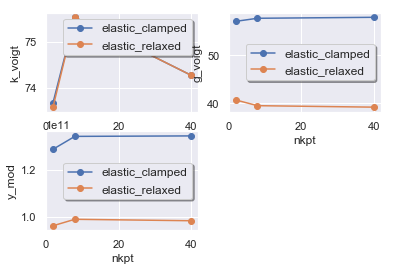

In [36]:
robot.plot_xy_with_hue(data, x="nkpt", y=["k_voigt", "g_voigt", "y_mod"], hue="tensor_name");

For more examples on the use of DDB and robots, see the 
[DDB notebook](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/ddb.ipynb)

Now let's try something a bit more complicated.
Assume we want to plot the convergence of the individual elements of the tensor as as function of `nkpt`.
In this case, we have to work a bit more to create a Dataframe with the elements in Voigt notation,
add the value of `nkpt` associated to this tensor and finally concatenate the results in a single DataFrame:

In [37]:
df_list = []
for edata, ddb in zip(elastdata_list, robot.abifiles):
    
    # Get dataframe with tensor elements in Voigt notation
    df = edata.get_elastic_voigt_dataframe()
    
    # Add metadata and store dataframe in df_list
    df["nkpt"] = ddb.header["nkpt"]
    df_list.append(df)
    
# Concatenate dataframes  
import pandas as pd
data = pd.concat(df_list)
data.head()

,voigt_cinds,elastic_relaxed,elastic_clamped,nkpt
0,"(0, 0)",1.526887e+02,1.778955e+02,2
1,"(0, 1)",5.327623e+01,3.828479e+01,2
2,"(0, 2)",2.952733e+01,1.722049e+01,2
3,"(0, 3)",-1.338671e-09,5.096042e-10,2
4,"(0, 4)",7.739802e-08,-2.507484e-09,2


To select only the (0, 0) elements, use the syntax:

In [38]:
C00 = data[data["voigt_cinds"] == (0, 0)]
C00

,voigt_cinds,elastic_relaxed,elastic_clamped,nkpt
0,"(0, 0)",152.688704,177.895514,2
0,"(0, 0)",135.262181,165.988592,8
0,"(0, 0)",130.988930,162.816605,40


Now we can finally plot the (0, 0) tensor elements as function of `nkpt` with:

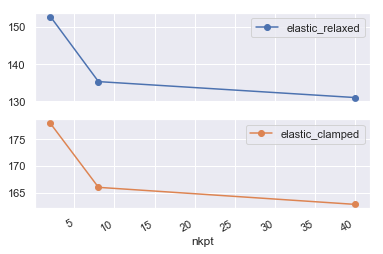

In [39]:
C00.plot(x="nkpt", y=[k for k in C00 if k.startswith("elastic_")], subplots=True, style="-o");

## Exercises
[[back to top](#top)]

Back to the main [Index](../index.ipynb)